In [2]:
import boto3
import json
import pandas as pd
import geopandas as gpd
#import plotly.graph_objects as go

from random import random
from tqdm.notebook import tqdm

import lib.data_models
import lib.data_converters

In [3]:
with open("s3_credentials.json", "r") as fp:
    s3_creds = json.load(fp)

In [4]:
class cfg: pass

cfg.S3_ENDPOINT_URL = "https://s3.netatmo.sitg-lab.ch"
cfg.S3_ACCESS_KEY = s3_creds["S3_ACCESS_KEY"]
cfg.S3_SECRET_KEY = s3_creds["S3_SECRET_KEY"]
cfg.S3_BUCKET = "netatmo"
mois ="7"
cfg.S3_PREFIX = "2023/2023-07"#/2023-09-01"

#cfg.SELECTED_SENSOR = "05:00:00:07:0d:b2"
cfg.SELECTED_SENSOR = "05:00:00:06:c1:98"

In [5]:
def df_to_gdf(df):

    gdf = gpd.GeoDataFrame(df.drop(['x', 'y', 'location'], axis=1), geometry=gpd.points_from_xy(df.x, df.y))
    gdf = gdf.set_crs(epsg=4326)

    return gdf


def extract_from_object(s3_client, s3_bucket, s3_key):

    def _make_df(parsed_raw_data):
        df = pd.DataFrame.from_records(lib.data_converters.na_data_file_body_converter(parsed_raw_data.body))   
        df[['x', 'y']] = df['location'].apply(pd.Series)
        
        return df
    

    #obj_path = f"{s3_client.meta.endpoint_url}/{s3_bucket}/{s3_key}"
    obj = s3_client.get_object(Bucket=s3_bucket, Key=s3_key)

    data_str = json.loads(obj['Body'].read())
    parsed_raw_data = lib.data_models.NADataFile.model_validate(data_str)

    df = _make_df(parsed_raw_data) #, obj_path)

    #SEL_MODULE_ID = cfg.SELECTED_SENSOR

    #return df.query(f"module_id == '{SEL_MODULE_ID}'")
    return df[df["measurement"].isin(["rain_live", 'rain_24h',
       'rain_60min'])]

def handle_object(s3_client, s3_bucket, s3_key):
    
    df = extract_from_object(s3_client, s3_bucket, s3_key)
    gdf = df_to_gdf(df)
    #cnt = load(cfg, gdfs)
    
    return gdf


In [6]:
s3_client = boto3.client('s3', 
    endpoint_url=cfg.S3_ENDPOINT_URL,
    aws_access_key_id=cfg.S3_ACCESS_KEY,
    aws_secret_access_key=cfg.S3_SECRET_KEY
)

In [7]:
for mois in ["12"]:
    cfg.S3_PREFIX = "2023/2023-" + mois
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=cfg.S3_BUCKET, Prefix=cfg.S3_PREFIX, MaxKeys=1000) 

    gdf = gpd.GeoDataFrame()

    for page_no, page in enumerate(pages):

        print(f"Page no. = {page_no + 1} - Memory usage = {gdf.memory_usage(index=True, deep=True).sum()}") 

        #for obj in sorted(page['Contents'], key=lambda _: random()):
        for obj in tqdm(page['Contents']):

            object_key = obj['Key']
            
            if not object_key.endswith('.json'):
                continue

            _gdf = handle_object(s3_client, cfg.S3_BUCKET, object_key)

            gdf = pd.concat([gdf, _gdf])

            #print(f"Cumulated no. of rows = {len(gdf)}")

            #break

    gdf = gdf.reset_index(drop=True)
    gdf.to_csv(f'data_total_{mois}_2023.csv')

Page no. = 1 - Memory usage = 132


  0%|          | 0/1000 [00:00<?, ?it/s]

Page no. = 2 - Memory usage = 344640513


  0%|          | 0/1000 [00:00<?, ?it/s]

Page no. = 3 - Memory usage = 689683857


  0%|          | 0/1000 [00:00<?, ?it/s]

Page no. = 4 - Memory usage = 1033964385


  0%|          | 0/304 [00:00<?, ?it/s]

In [ ]:
gdf.module_id.unique()

array(['05:00:00:01:9a:fe', '05:00:00:02:04:92', '05:00:00:09:0f:24',
       '05:00:00:0a:43:1a', '05:00:00:06:e9:d2', '05:00:00:06:30:9a',
       '05:00:00:09:22:36', '05:00:00:0a:9a:98', '05:00:00:0a:9d:10',
       '05:00:00:0a:bc:e8', '05:00:00:01:25:a6', '05:00:00:06:2f:f8',
       '05:00:00:08:cd:36', '05:00:00:03:87:8c', '05:00:00:05:11:bc',
       '05:00:00:0a:95:ea', '05:00:00:08:2e:00', '05:00:00:02:69:94',
       '05:00:00:02:83:a4', '05:00:00:00:f8:7e', '05:00:00:01:c2:a2',
       '05:00:00:09:a7:76', '05:00:00:02:b0:b2', '05:00:00:09:71:e8',
       '05:00:00:0a:be:0a', '05:00:00:05:1f:aa', '05:00:00:02:e9:4c',
       '05:00:00:0a:8f:0c', '05:00:00:09:7a:14', '05:00:00:02:fd:b0',
       '05:00:00:07:e2:52', '05:00:00:09:a0:e4', '05:00:00:03:fe:66',
       '05:00:00:05:c7:b6', '05:00:00:02:fe:da', '05:00:00:09:7c:82',
       '05:00:00:0a:02:92', '05:00:00:0a:99:9a', '05:00:00:00:90:30',
       '05:00:00:0a:9d:5c', '05:00:00:0a:91:7c', '05:00:00:09:cd:5c',
       '05:00:00:09:

In [14]:
gdf.to_csv(f'data_total_{mois}_2023.csv')  

In [40]:
gdf.memory_usage(index=True, deep=True).sum()

505907600

In [7]:
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   module_id    10302 non-null  object             
 1   module_type  10302 non-null  object             
 2   timezone     10302 non-null  object             
 3   country      10302 non-null  object             
 4   altitude     10302 non-null  int64              
 5   city         10302 non-null  object             
 6   street       10302 non-null  object             
 7   measurement  10302 non-null  object             
 8   time         10302 non-null  datetime64[ns, UTC]
 9   value        10302 non-null  float64            
 10  geometry     10302 non-null  geometry           
dtypes: datetime64[ns, UTC](1), float64(1), geometry(1), int64(1), object(7)
memory usage: 5.1 MB


In [26]:
gdf.time.unique()

<DatetimeArray>
['2023-09-01 00:57:37+00:00', '2023-09-01 01:07:39+00:00',
 '2023-09-01 01:17:42+00:00', '2023-09-01 01:27:44+00:00',
 '2023-09-01 01:37:47+00:00', '2023-09-01 01:48:02+00:00',
 '2023-09-01 01:58:04+00:00', '2023-09-01 02:08:07+00:00',
 '2023-09-01 02:18:09+00:00', '2023-09-01 02:28:12+00:00',
 ...
 '2023-09-30 21:18:36+00:00', '2023-09-30 21:28:38+00:00',
 '2023-09-30 21:38:40+00:00', '2023-09-30 21:48:43+00:00',
 '2023-09-30 22:59:13+00:00', '2023-09-30 23:09:15+00:00',
 '2023-09-30 23:19:17+00:00', '2023-09-30 23:29:20+00:00',
 '2023-09-30 23:39:22+00:00', '2023-09-30 23:49:25+00:00']
Length: 3416, dtype: datetime64[ns, UTC]

In [17]:
sorted(gdf[gdf.measurement == 'rain_60min'].value.unique())

[0.0,
 0.101,
 0.202,
 0.30300000000000005,
 0.404,
 0.505,
 0.6060000000000001,
 0.7070000000000001,
 0.808,
 0.909,
 1.01,
 1.111,
 1.2120000000000002,
 1.3130000000000002,
 1.4140000000000001,
 1.5150000000000001,
 1.616,
 1.717,
 1.818,
 1.919,
 2.121,
 2.222,
 2.323,
 2.4240000000000004,
 2.5250000000000004,
 2.6260000000000003,
 2.7270000000000003,
 2.9290000000000003,
 3.0300000000000002,
 3.333,
 3.535,
 3.636,
 3.737,
 3.838,
 3.939,
 4.04,
 4.242,
 4.343,
 4.444,
 4.848000000000001,
 4.949000000000001,
 5.050000000000001,
 5.252000000000001,
 5.353000000000001,
 5.454000000000001,
 5.555000000000001,
 5.656000000000001,
 6.1610000000000005,
 6.969,
 7.777,
 8.686,
 13.938]

In [16]:
sorted(gdf[gdf.measurement == 'rain_live'].value.unique())

[0.0,
 0.101,
 0.202,
 0.30300000000000005,
 0.404,
 0.505,
 0.6060000000000001,
 0.7070000000000001,
 0.909,
 2.7270000000000003]

In [16]:
gdf.head(5)

module_id module_type      timezone country  altitude   city  \
0  05:00:00:06:c1:98   NAModule3  Europe/Paris      FR       467  Ornex   
1  05:00:00:06:c1:98   NAModule3  Europe/Paris      FR       467  Ornex   
2  05:00:00:06:c1:98   NAModule3  Europe/Paris      FR       467  Ornex   
3  05:00:00:06:c1:98   NAModule3  Europe/Paris      FR       467  Ornex   
4  05:00:00:06:c1:98   NAModule3  Europe/Paris      FR       467  Ornex   

                          street measurement                      time  value  \
0  Rue des Hautains de la Crotte  rain_60min 2023-09-01 00:57:37+00:00    0.0   
1  Rue des Hautains de la Crotte    rain_24h 2023-09-01 00:57:37+00:00    0.0   
2  Rue des Hautains de la Crotte   rain_live 2023-09-01 00:57:37+00:00    0.0   
3  Rue des Hautains de la Crotte  rain_60min 2023-09-01 01:07:39+00:00    0.0   
4  Rue des Hautains de la Crotte    rain_24h 2023-09-01 01:07:39+00:00    0.0   

                   geometry  
0  POINT (6.10133 46.27036)  
1  POINT (6.10133 46.27036)  
2  POINT (6.10133 46.27036)  
3  POINT (6.10133 46.27036)  
4  POINT (6.10133 46.27036)

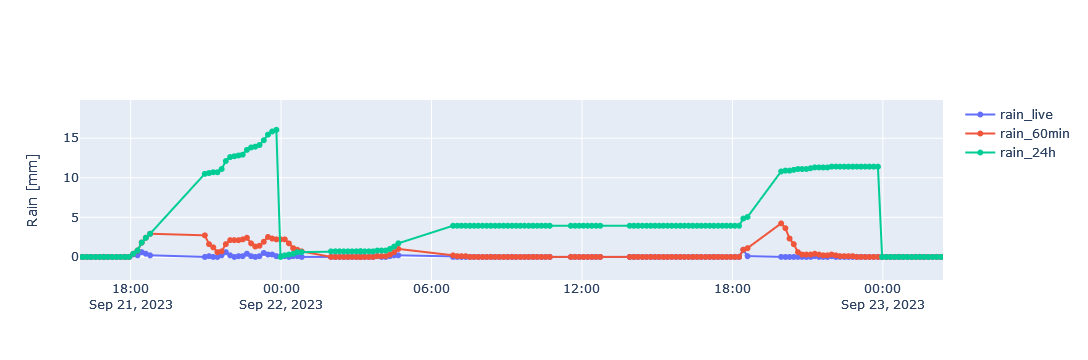

In [22]:
gdf['time'] = gdf.time.dt.tz_convert("Europe/Zurich")

fig = go.Figure()

sel_gdf = gdf[gdf.measurement == 'rain_live']

fig.add_trace(go.Scatter(x=sel_gdf.time, y=sel_gdf.value, name='rain_live', mode='lines+markers')) 

sel_gdf = gdf[gdf.measurement == 'rain_60min']

fig.add_trace(go.Scatter(x=sel_gdf.time, y=sel_gdf.value, name='rain_60min', mode='lines+markers')) 

sel_gdf = gdf[gdf.measurement == 'rain_24h']

fig.add_trace(go.Scatter(x=sel_gdf.time, y=sel_gdf.value, name='rain_24h', mode='lines+markers')) 

fig.update_layout(yaxis_title="Rain [mm]")
fig.show()

In [18]:
cfg.SELECTED_SENSOR.replace(":", "")

'05000006c198'

In [20]:
gdf.to_pickle(f'output/{cfg.SELECTED_SENSOR.replace(":", "")}-202309.pkl')

In [27]:
live_gdf = gdf[gdf.measurement == 'rain_live'][['time', 'value']].copy()

In [28]:
live_gdf.time.dt.tz_convert("Europe/Zurich")

2       2023-09-01 02:57:37+02:00
5       2023-09-01 03:07:39+02:00
8       2023-09-01 03:17:42+02:00
11      2023-09-01 03:27:44+02:00
14      2023-09-01 03:37:47+02:00
                   ...           
10289   2023-10-01 01:09:15+02:00
10292   2023-10-01 01:19:17+02:00
10295   2023-10-01 01:29:20+02:00
10298   2023-10-01 01:39:22+02:00
10301   2023-10-01 01:49:25+02:00
Name: time, Length: 3434, dtype: datetime64[ns, Europe/Zurich]

In [29]:
resampled_daily_gdf = live_gdf.resample('1H', on='time', origin='epoch').sum().reset_index()
resampled_daily_gdf['time'] = resampled_daily_gdf['time'].dt.tz_convert("Europe/Zurich")

resampled_daily_gdf

time  value
0   2023-09-01 02:00:00+02:00    0.0
1   2023-09-01 03:00:00+02:00    0.0
2   2023-09-01 04:00:00+02:00    0.0
3   2023-09-01 05:00:00+02:00    0.0
4   2023-09-01 06:00:00+02:00    0.0
..                        ...    ...
715 2023-09-30 21:00:00+02:00    0.0
716 2023-09-30 22:00:00+02:00    0.0
717 2023-09-30 23:00:00+02:00    0.0
718 2023-10-01 00:00:00+02:00    0.0
719 2023-10-01 01:00:00+02:00    0.0

[720 rows x 2 columns]

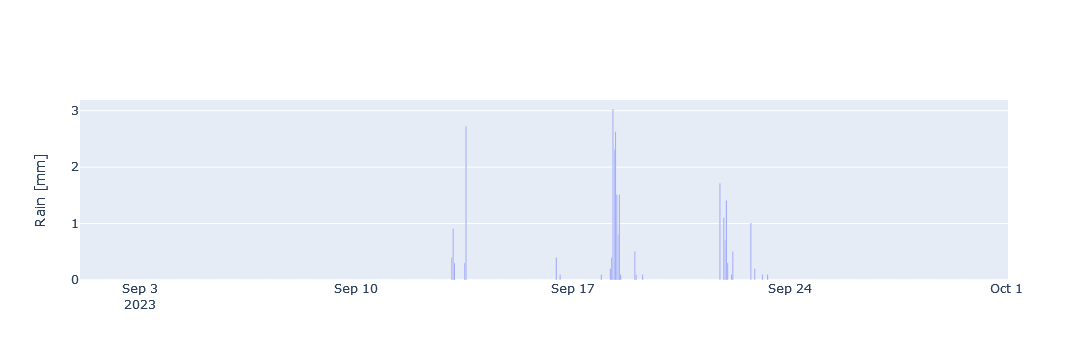

In [15]:
fig = go.Figure()

sel_gdf = resampled_daily_gdf.copy()

fig.add_trace(go.Bar(x=sel_gdf.time, y=sel_gdf.value))
fig.update_layout(yaxis_title="Rain [mm]")

fig.show()